# Image Augmentation Rotation by 45,0 and flipping

In [3]:
import tensorflow as tf
import os
import pandas as pd

# Read the label DataFrame
label_df = pd.read_excel('C:\\Fetal_Brain\\FETAL_PLANES_DB_data.xlsx')
# Read the augmented DataFrame
augmented_df = pd.read_csv('C:\\Fetal_Brain\\AugmentedImages.csv')

def rotate_image(image, angle):
    """Rotate the image by a given angle."""
    rotated_image = tf.image.rot90(image, k=angle // 45)
    return rotated_image

def flip_image(image, flip_code):
    """Flip the image horizontally or vertically."""
    flipped_image = tf.image.flip_left_right(image) if flip_code == 1 else tf.image.flip_up_down(image)
    return flipped_image

# Directory containing images to be augmented
input_dir = "C:\\Fetal_Brain\\CroppedImages\\"
# Directory to save augmented images
save_dir = "C:\\Fetal_Brain\\AugmentedImages\\"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Augmentation parameters
rotation_angles = [0,45]  # Rotate by 45 degrees increments
flip_codes = [0, 1, 2]  # Flip horizontally, vertically, and both

# Iterate over each image in the directory
for image_file in os.listdir(input_dir):
    if image_file.endswith('.png'):
        # Load the image
        image_path = os.path.join(input_dir, image_file)
        image = tf.image.decode_image(tf.io.read_file(image_path), channels=1)
        # Get label for the image
        label = label_df['Train '][label_df['Image_name'] == os.path.basename(image_path).split('.')[0]].values[0]

        # Apply augmentation
        augmented_images = []
        for angle in rotation_angles:
            rotated_image = rotate_image(image, angle)  # Skip resizing here
            for flip_code in flip_codes:
                flipped_image = flip_image(rotated_image, flip_code)
                augmented_images.append(flipped_image)

        # Save augmented images
        for i, augmented_image in enumerate(augmented_images):
            # Convert image to uint8
            augmented_image = tf.image.convert_image_dtype(augmented_image, dtype=tf.uint8)
            # Generate filename
            filename = os.path.basename(image_path).split('.')[0] + f"_augmented_{i}.png"
            # Save image
            tf.io.write_file(os.path.join(save_dir, filename), tf.image.encode_png(augmented_image))
            # Update augmented DataFrame
            # augmented_df = augmented_df.append(pd.DataFrame({'Image_name': [filename], 'Train': [label]}), ignore_index=True)
            new_data = pd.DataFrame({'Image_name': [filename], 'Train': [label]})
            augmented_df = pd.concat([augmented_df, new_data], ignore_index=True)
# Save the updated augmented DataFrame
augmented_df.to_csv('C:\\Fetal_Brain\\AugmentedImages.csv', index=False)


# SVM

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Load the preprocessed images and corresponding labels
image_directory = 'C:\\Fetal_Brain\\AugmentedImages'
labels_file = 'C:\\Fetal_Brain\\AugmentedImages.csv'
labels_df = pd.read_csv(labels_file)

# Prepare the data
images = []
labels = []
for filename in os.listdir(image_directory):
    image_path = os.path.join(image_directory, filename)
    if os.path.isfile(image_path):
        image_name = filename.split(".")[0] 
        label_row = labels_df.loc[labels_df['Image_name'] == image_name]
        if not label_row.empty:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            resized_image = cv2.resize(image, (224, 224))
            images.append(resized_image.flatten())  # Flatten the image
            labels.append(label_row.iloc[0]['Train'])

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# Define SVM models with different kernels
kernels = ['linear', 'poly', 'rbf']
accuracies = []

for kernel in kernels:
    # Define the SVM model
    svm_model = SVC(kernel=kernel)
    
    # Train the SVM model
    svm_model.fit(X_train_normalized, y_train)
    
    # Evaluate the SVM model
    test_accuracy = svm_model.score(X_test_normalized, y_test)
    accuracies.append(test_accuracy)

# Plot the accuracies
plt.bar(kernels, accuracies)
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('Accuracy of SVM with Different Kernels')
plt.ylim(0, 1)
plt.show()


In [2]:
accuracies

[0.7664670658682635, 0.7944111776447106, 0.7664670658682635]

In [9]:
kernels = ['linear', 'poly', 'rbf']
accuracies = [0.7664670658682635, 0.7944111776447106, 0.7664670658682635]

In [10]:
for _ in range(3):
  print(f"{kernels[_]} :- {accuracies[_]*100} %")

linear :- 76.64670658682635 %
poly :- 79.44111776447106 %
rbf :- 76.64670658682635 %


# Random Forest

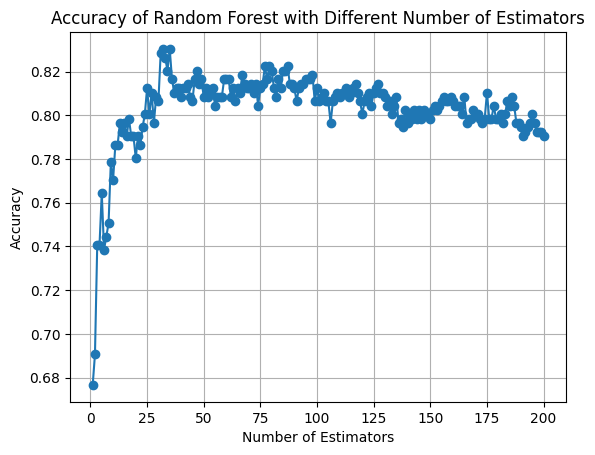

In [3]:
from sklearn.ensemble import RandomForestClassifier

# Define range of values for n_estimators
n_estimators_values = range(1, 201)

# Define empty list to store accuracies
rf_accuracies = []

# Iterate over different values of n_estimators
for n_estimators in n_estimators_values:
    # Define the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Train the Random Forest model
    rf_model.fit(X_train_normalized, y_train)
    
    # Evaluate the Random Forest model
    test_accuracy = rf_model.score(X_test_normalized, y_test)
    rf_accuracies.append(test_accuracy)

# Plot the accuracies for different values of n_estimators
plt.plot(n_estimators_values, rf_accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy of Random Forest with Different Number of Estimators')
plt.grid(True)
plt.show()


#Maximum accuracy of 83% on 31 estimators

In [4]:
max(rf_accuracies)

0.8303393213572854

In [5]:
rf_accuracies.index(0.8303393213572854)

31

# Logistic Regression

C:\Users\91705\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\91705\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

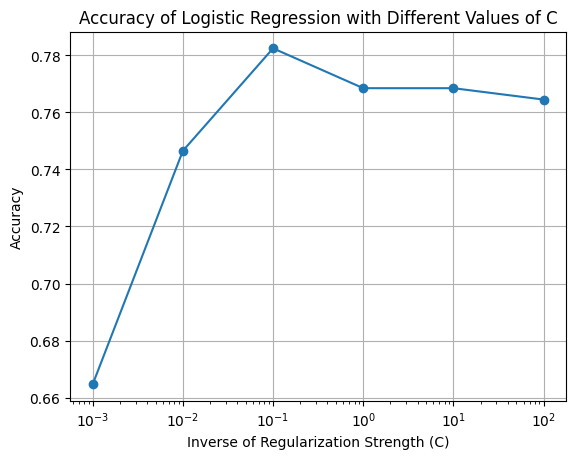

In [6]:
from sklearn.linear_model import LogisticRegression

# Define empty list to store logistic regression accuracies
lr_accuracies = []

# Iterate over different values of C (inverse of regularization strength)
for C_value in [0.001, 0.01, 0.1, 1, 10, 100]:
    # Define the logistic regression model
    lr_model = LogisticRegression(C=C_value, random_state=42)
    
    # Train the logistic regression model
    lr_model.fit(X_train_normalized, y_train)
    
    # Evaluate the logistic regression model
    test_accuracy = lr_model.score(X_test_normalized, y_test)
    lr_accuracies.append(test_accuracy)

# Plot the accuracies for different values of C
plt.plot([0.001, 0.01, 0.1, 1, 10, 100], lr_accuracies, marker='o')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Inverse of Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.title('Accuracy of Logistic Regression with Different Values of C')
plt.grid(True)
plt.show()


In [7]:
max(lr_accuracies)

0.782435129740519

# CNN

16/16 [==============================] - 3s 192ms/step - loss: 1.3444 - accuracy: 0.7824


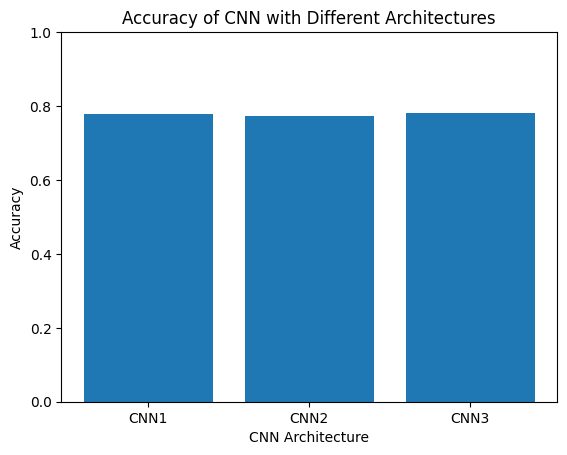

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load the preprocessed images and corresponding labels
image_directory = 'C:\\Fetal_Brain\\AugmentedImages'
labels_file = 'C:\\Fetal_Brain\\AugmentedImages.csv'
labels_df = pd.read_csv(labels_file)

# Prepare the data
images = []
labels = []
for filename in os.listdir(image_directory):
    image_path = os.path.join(image_directory, filename)
    if os.path.isfile(image_path):
        image_name = filename.split(".")[0] 
        label_row = labels_df.loc[labels_df['Image_name'] == image_name]
        if not label_row.empty:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            resized_image = cv2.resize(image, (224, 224))  # Resize image to (224, 224)
            flattened_image = resized_image.flatten()  # Flatten the image
            images.append(flattened_image)
            labels.append(label_row.iloc[0]['Train'])

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# Reshape input data to match the expected input shape of the CNN model
X_train_reshaped = X_train_normalized.reshape(-1, 224, 224, 1)
X_test_reshaped = X_test_normalized.reshape(-1, 224, 224, 1)

# Define empty list to store CNN accuracies
cnn_accuracies = []

# Define different CNN architectures to evaluate
architectures = [
    {'conv_layers': 1, 'filters': 32, 'kernel_size': (3, 3), 'fc_layers': 1},
    {'conv_layers': 2, 'filters': 64, 'kernel_size': (3, 3), 'fc_layers': 1},
    {'conv_layers': 3, 'filters': 64, 'kernel_size': (3, 3), 'fc_layers': 2}
]

# Iterate over different CNN architectures
for arch in architectures:
    # Define the CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(arch['filters'], arch['kernel_size'], activation='relu', input_shape=(224, 224, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    for _ in range(arch['conv_layers'] - 1):
        model.add(layers.Conv2D(arch['filters'], arch['kernel_size'], activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    for _ in range(arch['fc_layers']):
        model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=0)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
    cnn_accuracies.append(test_acc)

# Plot the accuracies for different CNN architectures
plt.bar(range(len(architectures)), cnn_accuracies)
plt.xticks(range(len(architectures)), ['CNN1', 'CNN2', 'CNN3'])
plt.xlabel('CNN Architecture')
plt.ylabel('Accuracy')
plt.title('Accuracy of CNN with Different Architectures')
plt.ylim(0, 1)
plt.show()


# KNN

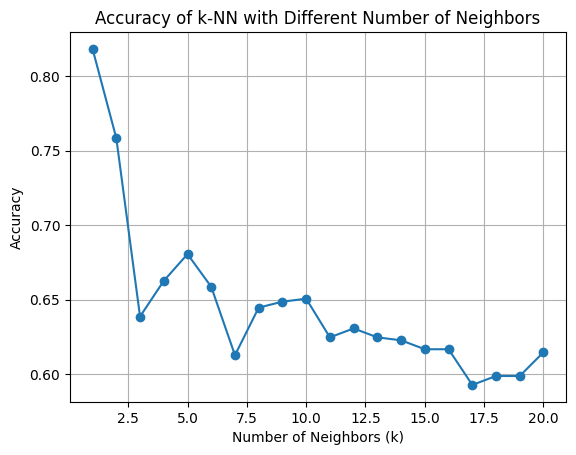

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Define range of values for k
k_values = range(1, 21)  # You can adjust the range as needed

# Define empty list to store accuracies
knn_accuracies = []

# Iterate over different values of k
for k in k_values:
    # Define the k-NN model
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # Train the k-NN model
    knn_model.fit(X_train_normalized, y_train)
    
    # Evaluate the k-NN model
    test_accuracy = knn_model.score(X_test_normalized, y_test)
    knn_accuracies.append(test_accuracy)

# Plot the accuracies for different values of k
plt.plot(k_values, knn_accuracies, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy of k-NN with Different Number of Neighbors')
plt.grid(True)
plt.show()


In [11]:
max(knn_accuracies)

0.8183632734530938

In [12]:
knn_accuracies.index(0.8183632734530938)

0

# ResNet

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the residual block
def residual_block(x, filters, kernel_size):
    y = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    y = layers.Conv2D(filters, kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.add([x, y])  # Skip connection
    return y

# Define the ResNet model
def ResNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Add residual blocks
    num_blocks = 3  # Number of residual blocks
    filters = 32  # Number of filters in each block
    for _ in range(num_blocks):
        x = residual_block(x, filters, (3, 3))

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Define the input shape and number of classes
input_shape = (224, 224, 1)  # Adjust this according to your input images
num_classes = 2  # Number of classes (binary classification)

# Create the ResNet model
resnet_model = ResNet(input_shape, num_classes)

# Compile the model
resnet_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Print the model summary
resnet_model.summary()

# Reshape input data to match the expected shape of the model's input layer
X_train_reshaped = X_train_normalized.reshape(-1, 224, 224, 1)
X_test_reshaped = X_test_normalized.reshape(-1, 224, 224, 1)

# Train the model
history = resnet_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model on the test data
test_loss, test_accuracy = resnet_model.evaluate(X_test_reshaped, y_test)
print('Test accuracy:', test_accuracy)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 222, 222, 32)         320       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 111, 111, 32)         9248      ['max_pooling2d_1[0][0]'

# Decision Tree

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load the preprocessed images and corresponding labels
image_directory='C:\\Fetal_Brain\\AugmentedImages'
labels_file = 'C:\\Fetal_Brain\\AugmentedImages.csv'
# Read labels from Excel file
labels_df = pd.read_csv(labels_file)
# labels_dict = dict(zip(labels_df['Image_name'], labels_df['Train ']))

# Prepare the data
images = []
labels = []
for filename in os.listdir(image_directory):
    image_path = os.path.join(image_directory, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    resized_image = cv2.resize(image, (224, 224))  
    images.append(resized_image.flatten()) 
    labels.append(labels_df.loc[labels_df['Image_name'] == filename.split(".")[0], 'Train'].values[0])


# Remove images with missing labels
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Initialize and train the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7604790419161677


# XGBoost

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import VGG16
from xgboost import XGBClassifier

# Load the preprocessed images and corresponding labels
image_directory = 'C:\\Fetal_Brain\\AugmentedImages'
labels_file = 'C:\\Fetal_Brain\\AugmentedImages.csv'

# Read labels from Excel file
labels_df = pd.read_csv(labels_file)
labels_dict = dict(zip(labels_df['Image_name'], labels_df['Train']))

# Prepare the data
images = []
labels = []
for filename in os.listdir(image_directory):
    image_path = os.path.join(image_directory, filename)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read image in color
    resized_image = cv2.resize(image, (224, 224))  
    images.append(resized_image) 
    labels.append(labels_df.loc[labels_df['Image_name'] == filename.split(".")[0], 'Train'].values[0])

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load pre-trained VGG16 model without classification layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using VGG16
X_train_features = vgg_model.predict(X_train)
X_test_features = vgg_model.predict(X_test)

# Flatten extracted features
X_train_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_flatten = X_test_features.reshape(X_test_features.shape[0], -1)

# Define and train XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_flatten, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_flatten)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy (XGBoost on VGG16 features):", accuracy)


16/16 [==============================] - 22s 1s/step
Test Accuracy (XGBoost on VGG16 features): 0.8303393213572854
